# Participants Classification based on Light-BGM model
by GONG ZERUI 2022.04.21

### 1. Load Libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
from numpy import pi 
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

### 2. Load Data

In [2]:
df_train = pd.read_csv("source/train.csv")
df_test = pd.read_csv("source/test.csv")

# combine both dataframes
df_train['Data'] = 'Train'
df_test['Data'] = 'Test'
df_total = pd.concat([df_train,df_test], axis = 0).reset_index(drop = True)
df_total['subject'] = '#' + df_total['subject'].astype(str)

# create label
activity_label = df_total.pop('Activity')

print('Shape Train:\t{}'.format(df_train.shape))
print('Shape Test:\t{}\n'.format(df_test.shape))

Shape Train:	(7352, 564)
Shape Test:	(2947, 564)



### 3. Classifying Participants data using Light-BGM model

In [3]:
activity_label_counts = activity_label.value_counts()

# iterate over each activity and print out the accuracy
for activity in activity_label_counts.index:

    activity_dataset = df_total[activity_label == activity].copy()
    activity_dataset.pop("Data")
    activity_subject = activity_dataset.pop("subject")

    # scale data and dimension reducing
    scl = StandardScaler()
    activity_dataset = scl.fit_transform(activity_dataset)

    pca = PCA(n_components=0.9, random_state=3)
    activity_dataset = pca.fit_transform(activity_dataset)

    # split train-test
    enc = LabelEncoder()
    label_encoded = enc.fit_transform(activity_subject)
    X_train, X_test, y_train, y_test = train_test_split(
        activity_dataset, label_encoded, random_state=3
    )

    # fit LBGM model
    print('Activity:'+ str(activity))
    lgbm = LGBMClassifier(n_estimators=1000, random_state = 3)
    lgbm = lgbm.fit(X_train, y_train)
    
    score = accuracy_score(y_true=y_test, y_pred=lgbm.predict(X_test))
    print('Accuracy:\t{:.8f}\n'.format(score))

Activity:LAYING
Accuracy:	0.64403292

Activity:STANDING
Accuracy:	0.54088050

Activity:SITTING
Accuracy:	0.53258427

Activity:WALKING
Accuracy:	0.96055684

Activity:WALKING_UPSTAIRS
Accuracy:	0.92487047

Activity:WALKING_DOWNSTAIRS
Accuracy:	0.91477273



We can see that it's very accurate to detect the specific person based on their activity. And the accuracy is much higher for movement. (96.1% for walking) This suggests we can find a unique movement pattern for each individual

### 4. Feature Importance

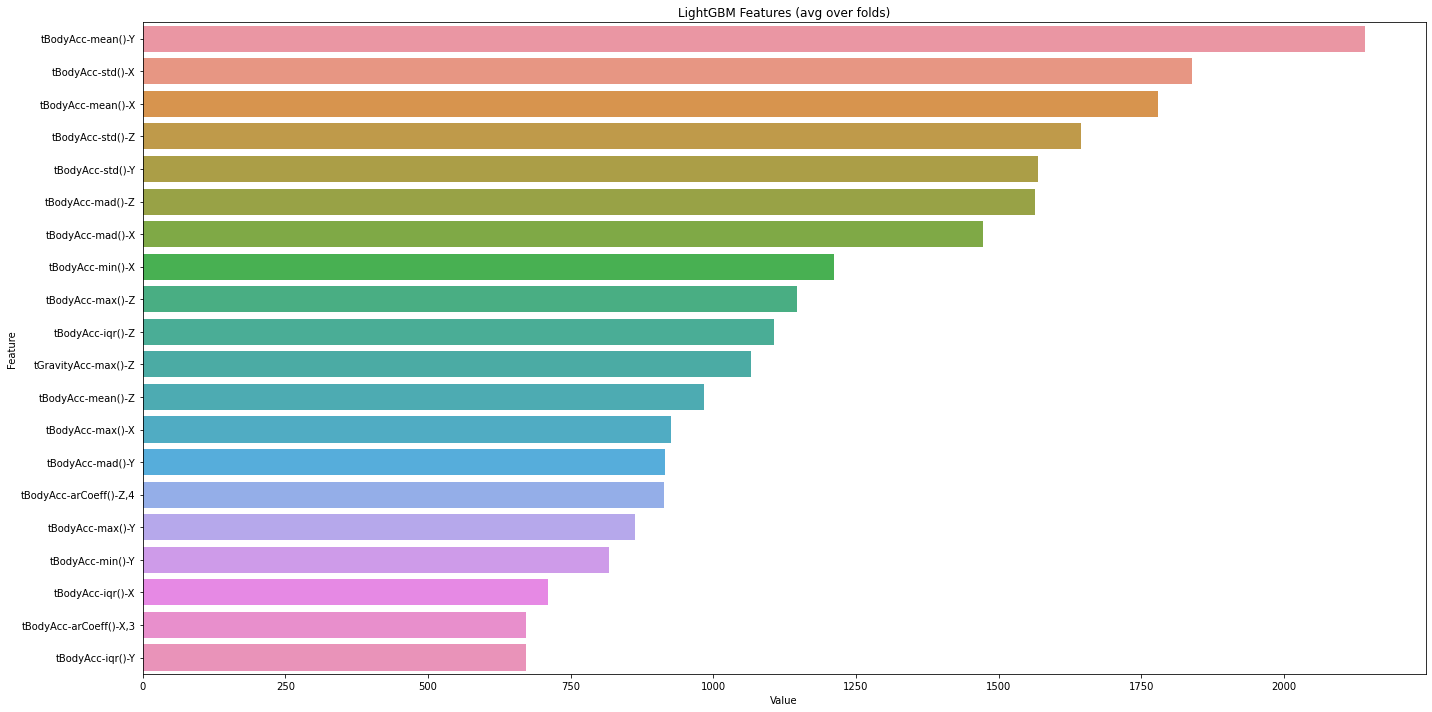

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_, df_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
# feature_importances = (feature_imp / sum(feature_imp)) * 100
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()